In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import os

from collections import defaultdict

%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.6f}'.format

import sys
sys.path.append("/home/evgenii/Projects/spring_moved_2018/")

import gym
from gym.wrappers import Monitor
import gym_ple

couldn't import doomish
Couldn't import doom


In [2]:
env = gym.make('FlappyBird-v0')

WARN: Environment '<class 'gym_ple.ple_env.PLEEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.


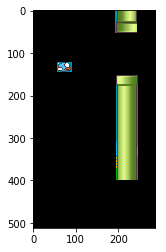

In [6]:
import cv2
from sklearn.cluster import DBSCAN
from itertools import chain
from skimage.io import imread

class PatternMatchCropper:
    def __init__(self):
        self.tube_pattern = self.__preprocess_image(imread("pics/pipe-green.png")[:25])
        self.inv_tube_pattern = np.flip(np.flip(self.tube_pattern, axis=0), axis=1)
        self.birb_pattern = self.__preprocess_image(imread("pics/yellowbird-downflap.png"))
        
    def __preprocess_image(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.Canny(image, 50, 200)
    
    def __find_candidates(self, image, pattern):
        image = self.__preprocess_image(image)
        res = cv2.matchTemplate(image, pattern, cv2.TM_CCOEFF_NORMED)
        
        return np.where(res == res.max())
    
    def __aggregate_candidates(self, candidates):
        dbscan = DBSCAN(min_samples=1, eps=1e1)
        points = np.vstack(candidates).T
        cluster_indices = dbscan.fit_predict(points)

        matches = pd.DataFrame(points[np.where(cluster_indices != -1)])
        matches["cluster"] = cluster_indices[np.where(cluster_indices != -1)]

        return np.flip(matches.groupby("cluster").mean().values.astype(int), axis=1)
    
    def __specify_tube_matches(self, matches, pattern, is_top=True):
        h, w = pattern.shape

        def specify_coords(coords):
            top_pt, bottom_pt = np.copy(coords), np.copy(coords)

            bottom_pt[0] += w

            if is_top:
                bottom_pt[1] = 400
            else:
                top_pt[1] = 0
                bottom_pt[1] += h

            return tuple(top_pt), tuple(bottom_pt)

        return list(map(specify_coords, matches))
    
    def __specify_birb_matches(self, matches, pattern):
        h, w = pattern.shape

        def specify_coords(coords):
            top_pt, bottom_pt = np.copy(coords), np.copy(coords)

            bottom_pt[0] += w
            bottom_pt[1] += h

            return tuple(top_pt), tuple(bottom_pt)

        return list(map(specify_coords, matches))
    
    def __find_tubes(self, image):
        cands = self.__find_candidates(image, self.tube_pattern)
        matches = self.__aggregate_candidates(cands)
        specified_matches = self.__specify_tube_matches(matches, self.tube_pattern, True)

        inv_cands = self.__find_candidates(image, self.inv_tube_pattern)
        inv_matches = self.__aggregate_candidates(inv_cands)
        inv_specified_matches = self.__specify_tube_matches(inv_matches, self.inv_tube_pattern, False)

        return chain(specified_matches, inv_specified_matches)

    def __find_birb(self, image):
        matches = self.__find_candidates(image, self.birb_pattern)
        return self.__specify_birb_matches(np.flip(np.vstack(matches).T, axis=1), self.birb_pattern)

    def __copy_regions(self, image, matches):
        new_image = np.zeros_like(image)

        for match in matches:
            (y1, x1), (y2, x2) = match
            new_image[x1:x2, y1:y2] = image[x1:x2, y1:y2]
        return new_image
    
    def crop_image(self, image):
        tube_matches = self.__find_tubes(image)
        birb_matches = self.__find_birb(image)
        matches = chain(tube_matches, birb_matches)
        
        return self.__copy_regions(image, matches)
    
pmc = PatternMatchCropper()
cropped_image = pmc.crop_image(s)
plt.imshow(cropped_image)

CPU times: user 179 ms, sys: 82.9 ms, total: 262 ms
Wall time: 59.9 ms


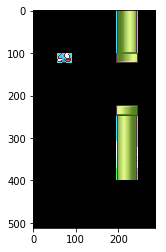

In [401]:
%%time

def find_candidates(image, pattern):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.Canny(image_gray, 50, 200)
    pattern_gray = cv2.cvtColor(pattern, cv2.COLOR_BGR2GRAY)
    pattern_gray = cv2.Canny(pattern_gray, 50, 200)
    res = cv2.matchTemplate(image_gray,pattern_gray,cv2.TM_CCOEFF_NORMED)
    threshold = 0.8
    loc = np.where(res >= res.max())
    
    return loc

def aggregate_candidates(candidates):
    dbscan = DBSCAN(min_samples=1, eps=1e1)
    points = np.vstack(candidates).T
    cluster_indices = dbscan.fit_predict(points)
    
    matches = pd.DataFrame(points[np.where(cluster_indices != -1)])
    matches["cluster"] = cluster_indices[np.where(cluster_indices != -1)]
    
    return np.flip(matches.groupby("cluster").mean().values.astype(int), axis=1)

def specify_matches(matches, pattern, is_top=True):
    pattern_gray = cv2.cvtColor(pattern, cv2.COLOR_RGB2GRAY)
    h, w = pattern_gray.shape
    
    def specify_coords(coords):
        top_pt, bottom_pt = np.copy(coords), np.copy(coords)
        
        bottom_pt[0] += w
        
        if is_top:
            bottom_pt[1] = IMAGE_HEIGHT-BASE_HEIGHT
        else:
            top_pt[1] = 0
            bottom_pt[1] += h
            
        return tuple(top_pt), tuple(bottom_pt)
    
    return list(map(specify_coords, matches))

def specify_matches_birb(matches, pattern):
    pattern_gray = cv2.cvtColor(pattern, cv2.COLOR_BGR2GRAY)
    h, w = pattern_gray.shape
    
    def specify_coords(coords):
        top_pt, bottom_pt = np.copy(coords), np.copy(coords)
        
        bottom_pt[0] += w
        bottom_pt[1] += h
            
        return tuple(top_pt), tuple(bottom_pt)
    
    return list(map(specify_coords, matches))

def draw_matches(image, matches):
    image_copy = image.copy()
    
    for match in matches:
        cv2.rectangle(image_copy, match[0], match[1], (255,255,255), 3)
        
    plt.imshow(image_copy)
    
def find_tubes(image, pattern, inv_pattern):
    cands = find_candidates(image, pattern)
    matches = aggregate_candidates(cands)
    specified_matches = specify_matches(matches, pattern, True)
    
    inv_cands = find_candidates(image, inv_pattern)
    inv_matches = aggregate_candidates(inv_cands)
    inv_specified_matches = specify_matches(inv_matches, inv_pattern, False)
    
    return chain(specified_matches, inv_specified_matches)

def find_birb(image, pattern):
    matches = find_candidates(image, pattern)
    return specify_matches_birb(np.flip(np.vstack(matches).T, axis=1), pattern)

def copy_regions(image, matches):
    new_image = np.zeros_like(image)
    
    for match in matches:
        (y1, x1), (y2, x2) = match
        new_image[x1:x2, y1:y2] = image[x1:x2, y1:y2]
    return new_image
    
tube_matches = find_tubes(s, tube, inv_tube)
birb_matches = find_birb(s, birb)
matches = chain(tube_matches, birb_matches)
#draw_matches(s, matches)
plt.imshow(copy_regions(s, matches))

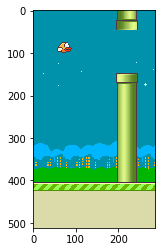

In [217]:
plt.imshow(s)

CPU times: user 106 ms, sys: 17.3 ms, total: 123 ms
Wall time: 34.1 ms


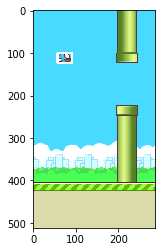

In [394]:
%%time

birb = imread("pics/yellowbird-downflap.png")
pattern = cv2.cvtColor(birb, cv2.COLOR_RGBA2RGB)

def find_candidates(image, pattern):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_gray = cv2.Canny(image_gray, 50, 200)
    pattern_gray = cv2.cvtColor(pattern, cv2.COLOR_RGB2GRAY)
    pattern_gray = cv2.Canny(pattern_gray, 50, 200)
    res = cv2.matchTemplate(image_gray,pattern_gray,cv2.TM_CCORR_NORMED)
    threshold = 0.6
    loc = np.where(res >= res.max())
    
    return loc



matches = find_candidates(s, pattern)
matches = specify_matches(np.flip(np.vstack(matches).T, axis=1), pattern)

draw_matches(s, matches)

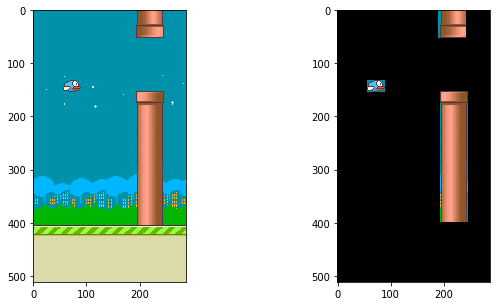

In [24]:
init_state = env.reset()

for _ in range(30):
    s, r, done, _ = env.step(env.action_space.sample())

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))    

ax1.imshow(s)
cropped_image = pmc.crop_image(s)
ax2.imshow(cropped_image)

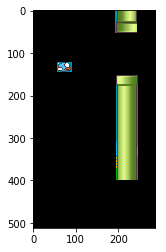

In [5]:
from croppers import PatternMatchCropper

pmc = PatternMatchCropper()
cropped_image = pmc.crop_image(s)
plt.imshow(cropped_image)